# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

## Part 2: Testing Modeling Approaches for Customer Segmentation Report

In this notebook, we'll be making tests with different approaches to address the KModes model for clustering.

In [2]:
pip install kmodes

Note: you may need to restart the kernel to use updated packages.


In [1]:
# setting random state for reproducibility
random_state = 22

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from kmodes.kmodes import KModes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# load in the data
azdias = pd.read_csv('data/clean_AZDIAS.csv')
customers = pd.read_csv('data/clean_CUSTOMERS.csv')

del azdias['Unnamed: 0']
del customers['Unnamed: 0']

In [3]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_MAINSTREAM
0,2,1.0,1.0,0.0,0.0,3.0,0.0,4.0,-1.0,-1.0,...,2.0,3.0,3.0,2.0,9.0,-1.0,3,0,3,1
1,-1,5.0,1.0,0.0,0.0,1.0,0.0,3.0,5.0,3.0,...,6.0,7.0,4.0,6.0,4.0,7.0,3,1,4,0
2,-1,1.0,1.0,0.0,0.0,1.0,0.0,4.0,-1.0,-1.0,...,10.0,10.0,10.0,-1.0,-1.0,-1.0,3,0,3,0
3,-1,1.0,2.0,0.0,0.0,3.0,0.0,4.0,6.0,4.0,...,4.0,7.0,4.0,3.0,9.0,3.0,1,1,1,1
4,-1,1.0,12.0,0.0,1.0,0.0,0.0,4.0,4.0,8.0,...,6.0,9.0,10.0,-1.0,5.0,1.0,5,0,1,1


### Modeling

KModes model is the one we chose because our variables are categorical.

KMeans (most commonly used clustering algorithm) uses distance to cluster data (the lesser the distance, the more similar the data points are so they are more likely to get clustered together). It makes a lot of sense to use it for continuous data.

But in this case, as we are dealing with categorical data points, it doesn't make sense to use distance measures.
KModes uses the dissimilarities, which means how mismatching the data points are between each other. The lesser the dissimilarities, the more similar the data points are so they will be clustered together.

As KMeans uses means, KModes uses modes instead.

Let's get started!

#### Approach 1 - No preprocessing

In [4]:
# Convert dataframe to matrix
azdiasMatrix = azdias.loc[:, azdias.columns].to_numpy()
azdiasMatrix

array([[ 2.,  1.,  1., ...,  0.,  3.,  1.],
       [-1.,  5.,  1., ...,  1.,  4.,  0.],
       [-1.,  1.,  1., ...,  0.,  3.,  0.],
       ...,
       [-1.,  9., 23., ...,  1.,  1.,  1.],
       [-1.,  9.,  1., ...,  1.,  4.,  0.],
       [-1.,  9.,  2., ...,  1.,  3.,  1.]])

In [9]:
# Choosing optimal K
cost = []
for cluster in range(1, 10):
    try:
        kmodes = KModes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = random_state)
        kmodes.fit_predict(azdiasMatrix)
        cost.append(kmodes.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
        
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster': range(1, 10), 'Cost': cost})
df_cost

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


,Cluster,Cost
0,1,36521626.0
1,2,31751160.0
2,3,30878330.0
3,4,30336226.0
4,5,29970633.0
5,6,29703112.0
6,7,29280042.0
7,8,29115538.0
8,9,29229564.0


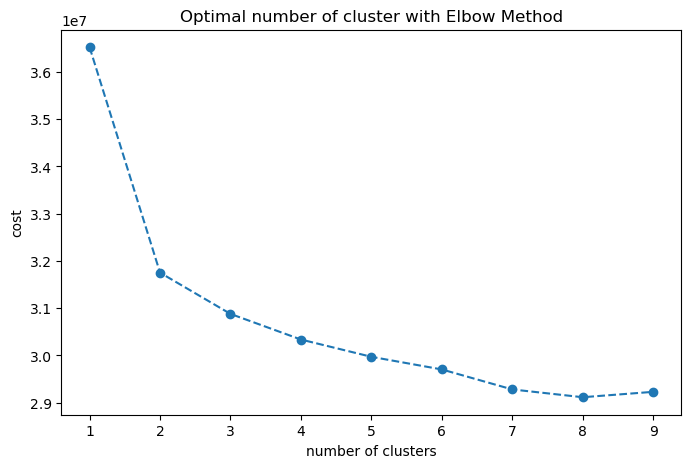

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(df_cost['Cluster'], df_cost['Cost'], linestyle='--', marker='o')
plt.xlabel('number of clusters')
plt.ylabel('cost')
plt.title('Optimal number of cluster with Elbow Method')
plt.show()

Although we have a clear elbow on 2 clusters, it doesn't seem like a good number to adopt in this situation.

In order to identify patterns on the population that would help identify new potential customers, we need to have more groups than just 2.

So let's test another approach and see if we get different results.

#### Approach 2 - Data Scaling and PCA

In [5]:
# Scale data
scaler = StandardScaler()

azdias_scaled = scaler.fit_transform(azdias)
customers_scaled = scaler.transform(customers)

In [15]:
# check the number of components to adopt
variance_dict = {}

for i in range(2, azdias.shape[1]-1, 2):
    pca = PCA(n_components = i, svd_solver = 'arpack')
    pca.fit(azdias_scaled)
    variance_dict[i] = pca.explained_variance_ratio_.sum().round(6)
    
print('Number of components and explained variance ratio:\n', variance_dict)

Number of components and explained variance ratio:
 {2: 0.353904, 4: 0.441787, 6: 0.493013, 8: 0.525995, 10: 0.547785, 12: 0.56597, 14: 0.581387, 16: 0.595022, 18: 0.607499, 20: 0.618931, 22: 0.629876, 24: 0.640349, 26: 0.65004, 28: 0.659013, 30: 0.667579, 32: 0.675752, 34: 0.683532, 36: 0.691008, 38: 0.698185, 40: 0.705056, 42: 0.711638, 44: 0.718042, 46: 0.724325, 48: 0.730434, 50: 0.736394, 52: 0.742291, 54: 0.748061, 56: 0.753731, 58: 0.75931, 60: 0.764783, 62: 0.770155, 64: 0.775433, 66: 0.780668, 68: 0.785782, 70: 0.790814, 72: 0.795734, 74: 0.800612, 76: 0.805421, 78: 0.810091, 80: 0.814667, 82: 0.819161, 84: 0.823598, 86: 0.82797, 88: 0.832256, 90: 0.836454, 92: 0.8406, 94: 0.844684, 96: 0.848721, 98: 0.852692, 100: 0.856576, 102: 0.860333, 104: 0.863985, 106: 0.867565, 108: 0.871079, 110: 0.874538, 112: 0.877902, 114: 0.881197, 116: 0.884426, 118: 0.887581, 120: 0.890616, 122: 0.893568, 124: 0.896439, 126: 0.899244, 128: 0.901948, 130: 0.904554, 132: 0.907087, 134: 0.909561, 1

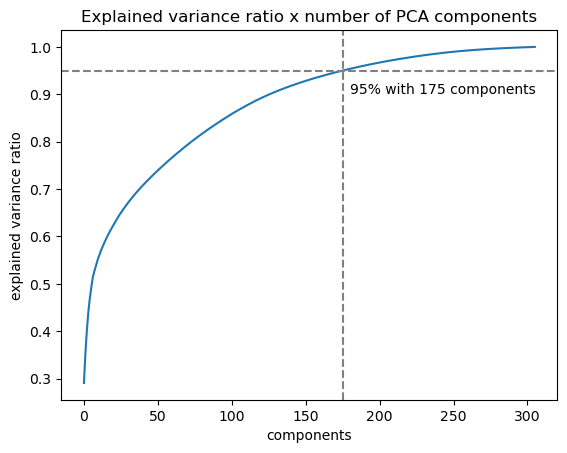

In [40]:
# plot the explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('components')
plt.ylabel('explained variance ratio')
plt.title('Explained variance ratio x number of PCA components')
plt.axhline(y=0.95, color = 'gray', linestyle='--')
plt.axvline(x=175, color = 'gray', linestyle='--')
plt.annotate('95% with 175 components', (180,0.9))
plt.show()

The explained variance ratio is at a good point with `175` components. That's what we'll adopt.

In [54]:
n_pca = 175

In [49]:
pca = PCA(n_components = n_pca, random_state=random_state)

azdias_pca = pca.fit_transform(azdias_scaled)
azdias_pca = pd.DataFrame(azdias_pca)

customer_pca = pca.transform(customers_scaled)
customer_pca = pd.DataFrame(customer_pca)

In [50]:
azdias_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
0,23.343832,-4.628701,3.835483,1.998733,6.508056,-0.484798,-2.559412,1.174411,-1.064732,-5.157687,...,-0.255048,-0.276655,-0.281140,0.310263,0.227106,0.312984,-0.383651,0.215756,0.131627,-0.128342
1,-4.569350,-2.435272,3.406104,-3.160105,-1.574794,1.130128,4.059791,-1.387436,-0.196403,0.026904,...,0.662589,0.044396,0.488007,0.764289,0.734052,0.333831,0.933615,0.503625,0.181919,-1.029556
2,26.317507,2.117681,1.666635,0.075645,-0.520019,0.273039,-0.436315,-0.728485,-0.649267,1.953181,...,0.157570,0.051654,-0.012363,-0.074085,-0.019007,-0.103738,-0.073566,-0.069084,-0.022639,-0.060446
3,-2.784811,-4.343535,-1.801208,4.441500,0.328897,-4.680964,2.733713,-3.140851,-4.006991,0.375700,...,-0.375073,-0.291295,-0.221150,-0.130565,-0.016662,0.009568,-0.660380,-0.829359,-0.070550,0.864306
4,-2.039155,3.688609,-4.134655,3.736520,-1.252272,4.609524,-3.029568,-0.590773,0.480284,-0.216105,...,-0.212681,0.090508,0.277919,0.818459,-0.882377,0.053823,-0.381644,-0.417264,-0.344189,-1.107298


In [51]:
# Convert dataframe to matrix
azdias_pcaMatrix = azdias_pca.loc[:, azdias_pca.columns].to_numpy()
azdias_pcaMatrix

array([[ 2.33438319e+01, -4.62870056e+00,  3.83548333e+00, ...,
         2.15756391e-01,  1.31627495e-01, -1.28341545e-01],
       [-4.56934991e+00, -2.43527236e+00,  3.40610367e+00, ...,
         5.03624625e-01,  1.81918957e-01, -1.02955627e+00],
       [ 2.63175074e+01,  2.11768063e+00,  1.66663514e+00, ...,
        -6.90842316e-02, -2.26389247e-02, -6.04458781e-02],
       ...,
       [-3.53588601e+00,  3.68284503e+00, -7.39120064e+00, ...,
        -2.13842535e-01,  3.92994534e-01, -6.74375211e-01],
       [-2.90020525e+00, -5.18790234e+00,  5.16908805e+00, ...,
         2.88054464e-01,  1.34842087e+00, -1.79281765e-01],
       [-2.23770238e+00, -4.73381520e-01, -1.62115656e+00, ...,
         1.36983355e-01, -2.81800075e-01,  4.44028046e-01]])

In [52]:
# Choosing optimal K
cost_pca = []
for cluster in range(1, 10):
    try:
        kmodes = KModes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = random_state)
        kmodes.fit_predict(azdias_pcaMatrix)
        cost_pca.append(kmodes.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
        
# Converting the results into a dataframe and plotting them
df_cost_pca = pd.DataFrame({'Cluster': range(1, 10), 'Cost': cost_pca})
df_cost_pca

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


,Cluster,Cost
0,1,38321315.0
1,2,37744505.0
2,3,37510001.0
3,4,37318020.0
4,5,37166992.0
5,6,37146512.0
6,7,36995484.0
7,8,36995309.0
8,9,36995134.0


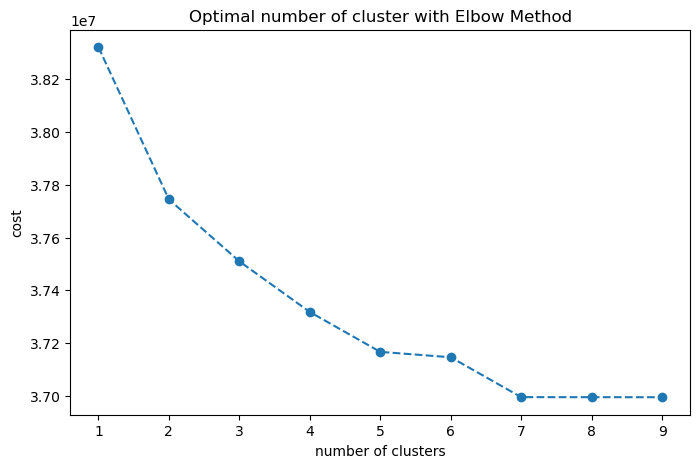

In [53]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(df_cost_pca['Cluster'], df_cost_pca['Cost'], linestyle='--', marker='o')
plt.xlabel('number of clusters')
plt.ylabel('cost')
plt.title('Optimal number of cluster with Elbow Method')
plt.show()

So now with this new approach, we have a more realistic plot.

In this case, we'll use n=5 for clustering.

See you on the next notebook!!